### Import Required Packages

In [6]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

### Download and load dataset: http://cs231n.stanford.edu/tiny-imagenet-200.zip

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


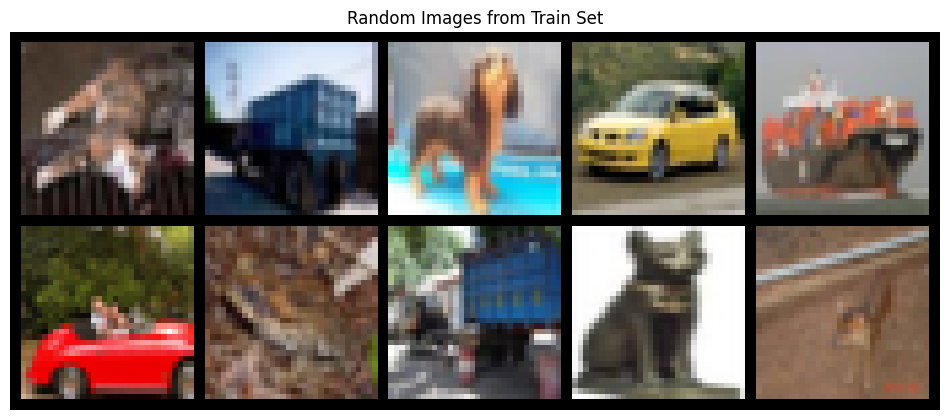

In [3]:
random_indices = random.sample(range(len(train_dataset)), 10)
images = [train_dataset[i][0] for i in random_indices]
labels = [train_dataset[i][1] for i in random_indices]

img_grid = torchvision.utils.make_grid(images, nrow=5, padding=2, normalize=True)

# Show the images
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(img_grid.numpy(), (1, 2, 0)))
plt.title("Random Images from Train Set")
plt.axis('off')
plt.show()

### Defining Configuration File

In [4]:
class AlexNetConfig:
    """
    Configuration class for AlexNet model adapted for CIFAR-10 (32x32 images).
    """
    dataset = 'cifar10'
    num_classes = 10
    conv1 = {'out_channels': 64}
    conv2 = {'out_channels': 192}
    conv3 = {'out_channels': 384}
    conv4 = {'out_channels': 256}
    conv5 = {'out_channels': 256}
    classifer_in = 256 * 2 * 2
    classifer_hidden = 100

In [5]:
# Definging Model
from Models.AlexNet import AlexNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlexNet(AlexNetConfig()).to(device)
print(f"DEVICE: {device}")

criterion = nn.CrossEntropyLoss()
Optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

DEVICE: cuda


**Model Summary**

In [11]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=1024, out_features=100, bias=True)
    (2): ReLU(inplace=True)
    (3): LayerNorm((100,)

## Training & Validation

In [7]:
def validate(model, val_loader, device):
    model.eval()
    y_preds = []
    y_trues = []

    with torch.no_grad():
        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            y_preds.extend(preds.cpu().numpy())
            y_trues.extend(Y.cpu().numpy())

    acc = accuracy_score(y_trues, y_preds)
    print("Validation Accuracy:", acc)

In [ ]:
iterations_per_epoch = len(train_loader)
for _ in range(5):
    model.train()
    total_loss = 0
    for i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)
        Optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs,Y)
        loss.backward()
        Optimizer.step()
        total_loss += loss.item()

        if i % 50 == 0:
            print(f"[{_}][{i+1}/{iterations_per_epoch}]-----------------------------------------------------------[{loss.item()}]-[{total_loss}]")
    validate(model, test_loader, device)

## Visuallizing Weights and Features

In [17]:
print(model.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


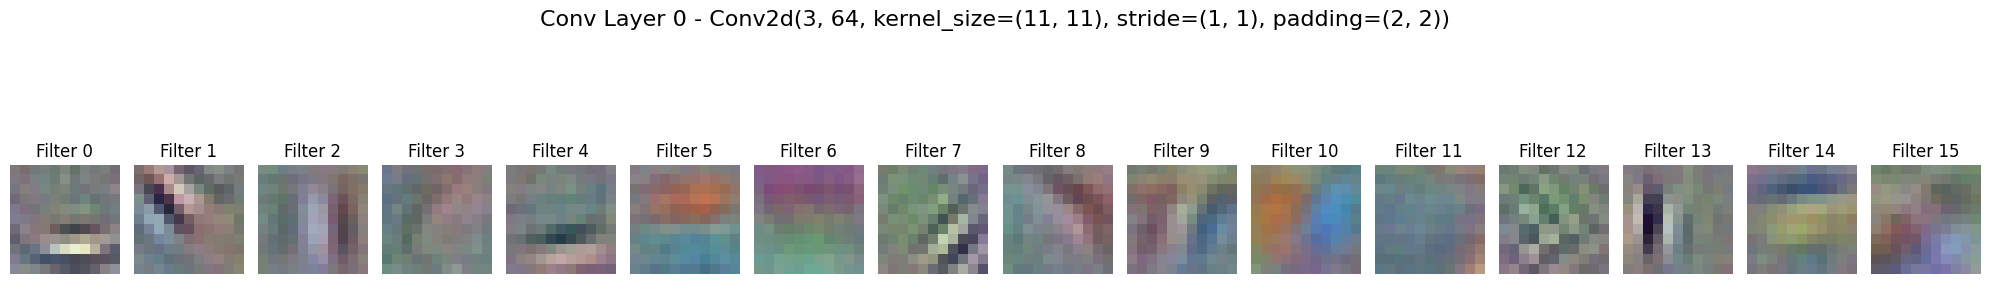

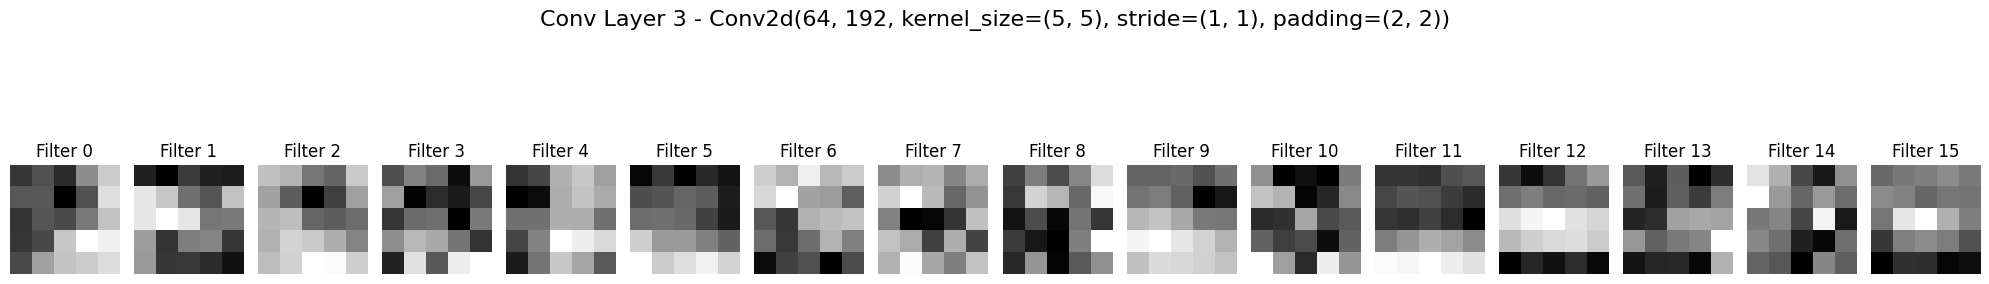

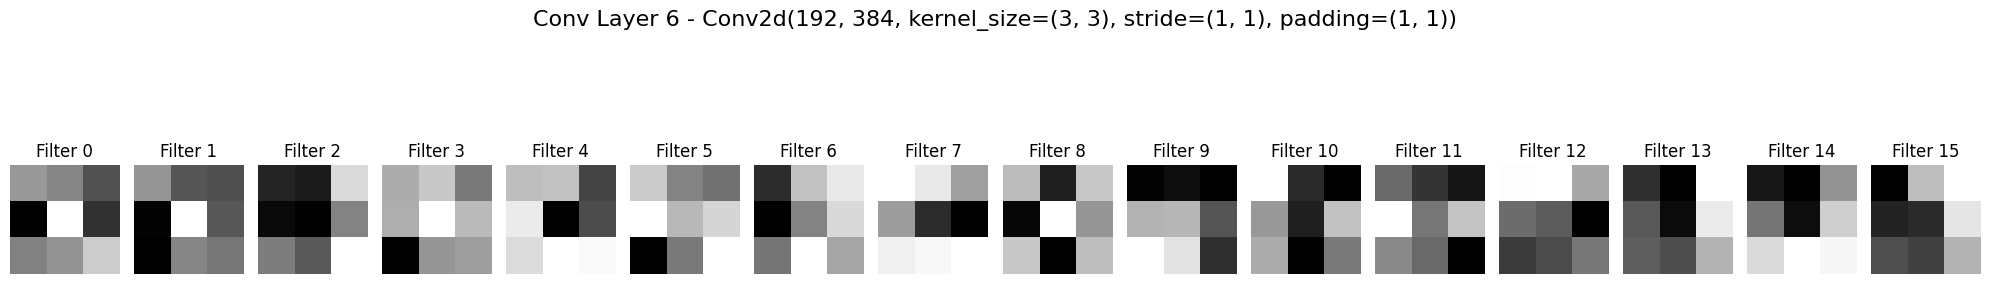

In [ ]:
# Weights Visualization
def visualize_conv_weights(layer, title, max_filters=16):
    """Visualize the first N filters of a Conv2d layer."""
    weights = layer.weight.data.cpu().clone()
    min_wt, max_wt = weights.min(), weights.max()
    weights = (weights - min_wt) / (max_wt - min_wt)  # normalize

    n_filters = min(weights.shape[0], max_filters)
    fig, axes = plt.subplots(1, n_filters, figsize=(20, 4))
    fig.suptitle(title, fontsize=16)

    for i in range(n_filters):
        # If the filter has 3 channels, show as RGB
        if weights.shape[1] == 3:
            img = weights[i].permute(1, 2, 0)  # C, H, W → H, W, C
        else:
            # Use first channel only for grayscale convs
            img = weights[i][0]
        axes[i].imshow(img.numpy(), cmap='gray' if weights.shape[1] != 3 else None)
        axes[i].axis('off')
        axes[i].set_title(f'Filter {i}')
    plt.tight_layout()
    plt.show()

# Assuming model.features is your Sequential module
conv_layer_indices = [0, 3, 6]  # Conv2d layers in your sequence
for idx in conv_layer_indices:
    layer = model.features[idx]
    visualize_conv_weights(layer, f"Conv Layer {idx} - {layer}")

In [24]:
# Feature Visuallization
def get_feature_maps(model, x, layers_to_hook):
    """Register forward hooks to capture feature maps."""
    feature_maps = {}

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach().cpu()
        return hook

    hooks = []
    for idx in layers_to_hook:
        layer = model.features[idx]
        h = layer.register_forward_hook(hook_fn(f"layer_{idx}"))
        hooks.append(h)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(x)

    # Remove hooks
    for h in hooks:
        h.remove()

    return feature_maps

def plot_feature_maps(feature_map, max_channels=16):
    """Plot the first few feature maps."""
    channels = feature_map.shape[1]
    n_plots = min(channels, max_channels)
    
    fig, axes = plt.subplots(1, n_plots, figsize=(20, 5))
    for i in range(n_plots):
        axes[i].imshow(feature_map[0, i], cmap='viridis')
        axes[i].axis('off')
        axes[i].set_title(f'Channel {i}')
    plt.tight_layout()
    plt.show()



Feature maps from layer_0 with shape torch.Size([1, 64, 26, 26])


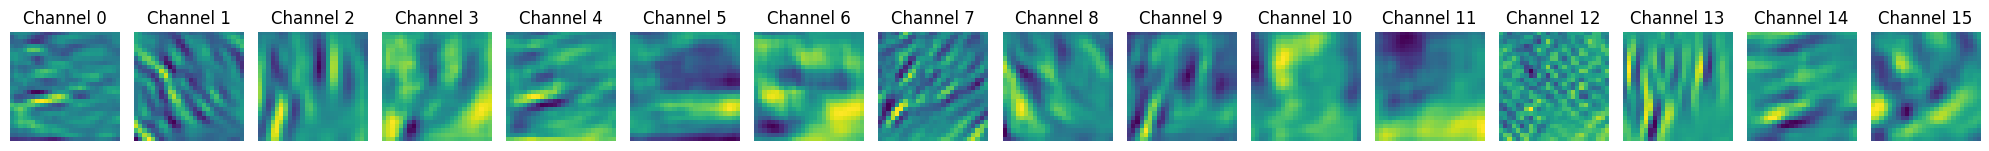


Feature maps from layer_3 with shape torch.Size([1, 192, 12, 12])


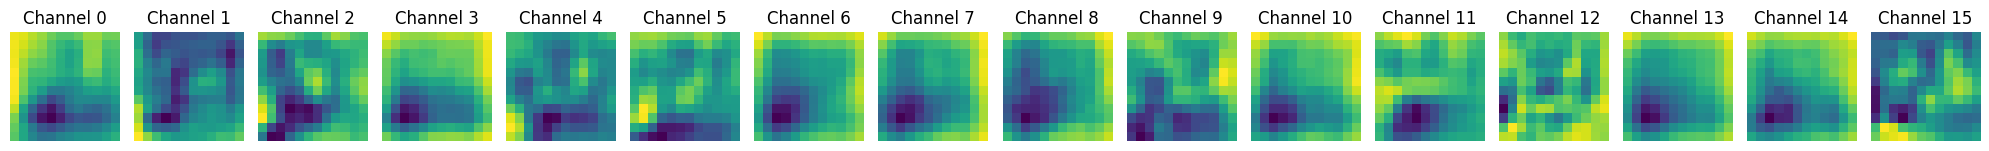


Feature maps from layer_6 with shape torch.Size([1, 384, 5, 5])


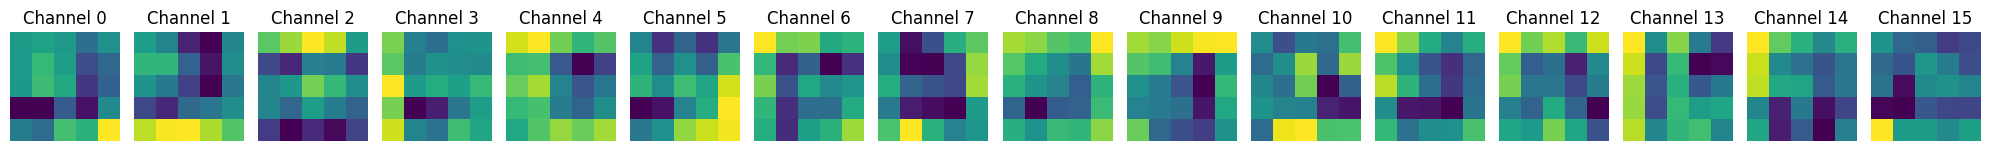

In [25]:
# Sample image from your dataset
X_sample, _ = next(iter(test_loader))  # One batch
X_sample = X_sample[0:1].to(device)   # Single image

# Layers you want to visualize (e.g., conv1, conv2, conv3)
layers_to_visualize = [0, 3, 6]

# Get feature maps
feature_maps = get_feature_maps(model, X_sample, layers_to_visualize)

# Plot them
for layer_name, fmap in feature_maps.items():
    print(f"\nFeature maps from {layer_name} with shape {fmap.shape}")
    plot_feature_maps(fmap)
